In [1]:
import pandas as pd
from PopSynthesis.Methods.BN.utils.learn_BN import learn_struct_BN_score, learn_para_BN
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
import random
import logging

logging.getLogger("pgmpy").setLevel(logging.ERROR)

In [2]:
syn_hh = pd.read_csv("../data/syn_hh_ipf.csv")
seed_pp = pd.read_csv("../data/pp_sample_ipu.csv")

In [ ]:
max_n_pp = 11

In [4]:
syn_hh

,hhsize,dwelltype,owndwell,hhinc,totalvehs,zone_id,serialno
0,1,Flat or Apartment,Being Rented,1000-1249,1,3000,1
1,1,Flat or Apartment,Being Rented,1000-1249,1,3000,2
2,1,Flat or Apartment,Being Rented,1000-1249,1,3000,3
3,1,Flat or Apartment,Being Rented,1000-1249,1,3000,4
4,1,Flat or Apartment,Being Rented,1000-1249,1,3000,5
...,...,...,...,...,...,...,...
2420216,5,Separate House,Being Purchased,400-499,4+,3996,2420217
2420217,5,Separate House,Being Purchased,8000+,4+,3996,2420218
2420218,8+,Separate House,Being Purchased,6000-7999,2,3996,2420219
2420219,8+,Separate House,Being Purchased,6000-7999,2,3996,2420220


  0%|          | 0/1000000 [00:00<?, ?it/s]

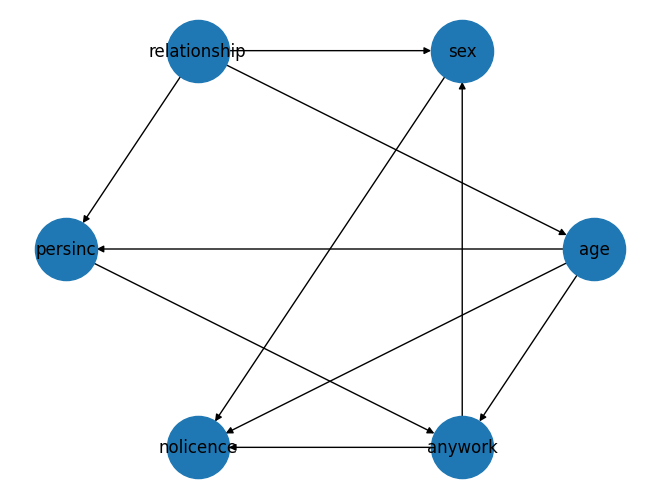

In [5]:
learn_df = seed_pp.drop(columns=["serialno", "sample_geog"])
model = learn_struct_BN_score(learn_df, show_struct=True)
model = learn_para_BN(model, learn_df)
sampler = BayesianModelSampling(model)

In [7]:
pool = sampler.forward_sample(size=10000000)

  0%|          | 0/6 [00:00<?, ?it/s]

In [13]:
main_pool = pool[pool["relationship"] == "Main"].value_counts().reset_index(name="count")
other_pool = pool[pool["relationship"] != "Main"].value_counts().reset_index(name="count")

In [16]:
syn_pp_results = []
for hhsz, hhid in zip(syn_hh["hhsize"], syn_hh["serialno"]):
    # print progress
    if hhid % 2000 == 0:
        print(f"Got to: {hhid}, {len(syn_hh) - hhid} left")
    if hhsz == "8+":
        hhsz = random.randint(8, max_n_pp)
    else:
        hhsz = int(hhsz)
    main_person = main_pool.sample(n=1, weights="count", replace=True)
    pp_results = [main_person]
    if hhsz > 1:
        others_pp = other_pool.sample(n=hhsz-1, weights="count", replace=True)
        pp_results.append(others_pp)
    hh_pp_results = pd.concat(pp_results, ignore_index=True)
    hh_pp_results["serialno"] = hhid
    syn_pp_results.append(hh_pp_results)
final_pp = pd.concat(syn_pp_results, ignore_index=True)

Got to: 2000, 2418221 left
Got to: 4000, 2416221 left
Got to: 6000, 2414221 left
Got to: 8000, 2412221 left
Got to: 10000, 2410221 left
Got to: 12000, 2408221 left
Got to: 14000, 2406221 left
Got to: 16000, 2404221 left
Got to: 18000, 2402221 left
Got to: 20000, 2400221 left
Got to: 22000, 2398221 left
Got to: 24000, 2396221 left
Got to: 26000, 2394221 left
Got to: 28000, 2392221 left
Got to: 30000, 2390221 left
Got to: 32000, 2388221 left
Got to: 34000, 2386221 left
Got to: 36000, 2384221 left
Got to: 38000, 2382221 left
Got to: 40000, 2380221 left
Got to: 42000, 2378221 left
Got to: 44000, 2376221 left
Got to: 46000, 2374221 left
Got to: 48000, 2372221 left
Got to: 50000, 2370221 left
Got to: 52000, 2368221 left
Got to: 54000, 2366221 left
Got to: 56000, 2364221 left
Got to: 58000, 2362221 left
Got to: 60000, 2360221 left
Got to: 62000, 2358221 left
Got to: 64000, 2356221 left
Got to: 66000, 2354221 left
Got to: 68000, 2352221 left
Got to: 70000, 2350221 left
Got to: 72000, 2348221 l

In [17]:
# 318m 56.7s

In [20]:
final_pp.to_csv("../output/syn_pp_bn_hhsz_constraint.csv", index=False)